In [1]:
!git clone 'https://github.com/shilpiprd/Biparietal_Occipitofrontal-Diameter-Detection.git'
# %cd ERA-Solution/Sess11\ Solution/

Cloning into 'Biparietal_Occipitofrontal-Diameter-Detection'...
remote: Enumerating objects: 627, done.
remote: Total 627 (delta 0), reused 0 (delta 0), pack-reused 627
Receiving objects: 100% (627/627), 79.61 MiB | 17.42 MiB/s, done.


In [2]:
%cd /content/Biparietal_Occipitofrontal-Diameter-Detection

/content/Biparietal_Occipitofrontal-Diameter-Detection


In [3]:
ls

images/  part_A.ipynb  role_challenge_dataset_ground_truth.csv  tryout_partA.ipynb


In [4]:
#run this
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
from PIL import Image
from PIL import Image, ImageOps
import scipy.ndimage


In [5]:
data = pd.read_csv('/content/Biparietal_Occipitofrontal-Diameter-Detection/role_challenge_dataset_ground_truth.csv')
images = os.listdir('/content/Biparietal_Occipitofrontal-Diameter-Detection/images/')
print(data.shape, len(images))
data.head(4)


(622, 9) 622


,image_name,ofd_1_x,ofd_1_y,ofd_2_x,ofd_2_y,bpd_1_x,bpd_1_y,bpd_2_x,bpd_2_y
0,000_HC.png,361,12,339,530,481,16,664,318
1,001_HC.png,441,331,368,308,297,247,534,142
2,002_HC.png,318,374,154,406,481,158,558,215
3,003_HC.png,424,105,407,462,305,349,547,363


In [6]:
#check all input image sizes
base_path = '/content/Biparietal_Occipitofrontal-Diameter-Detection/images'
image_paths = os.listdir(base_path)
s = set()
for image_path in image_paths:
      actual_path = os.path.join(base_path, image_path)
      with Image.open(actual_path).convert('L') as img: #l is for grayscale mode
            original_shape = img.size
            # print(original_shape)
            s.add(original_shape)
print(s)

{(794, 544), (790, 539), (800, 540), (797, 541), (780, 544), (794, 543), (783, 543), (799, 563), (738, 541), (788, 545), (786, 542), (800, 542), (780, 539), (782, 542), (783, 541)}


original_image.size:  (800, 540)


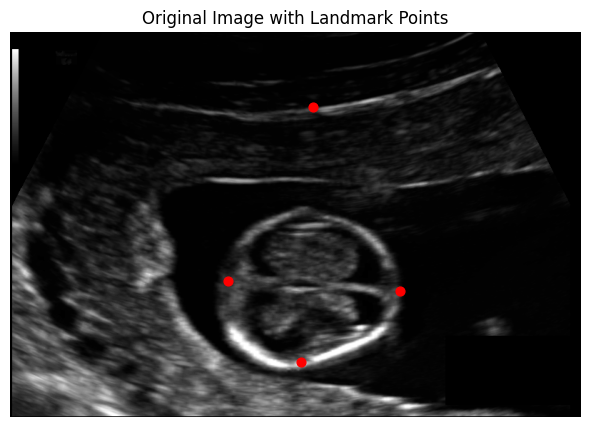

In [7]:
#take a look at the data given: plot original coordinates on original image
def visualize_individual_points(image, coordinates):
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap='gray', aspect='equal')
    for coord in coordinates:
        x, y = coord
        x, y = int(x), int(y)  # Ensure coordinates are integers
        plt.scatter([x], [y], c='r', s=40)
    plt.title("Original Image with Landmark Points")
    plt.axis('off')
    plt.show()

original_image = Image.open('/content/Biparietal_Occipitofrontal-Diameter-Detection/images/003_HC.png').convert('L')
print('original_image.size: ', original_image.size)
image = np.array(original_image)/ 255.0 #normalizing
my_coord = [(424, 105), (407, 462), (305, 349), (547, 363)] #wrote myself
visualize_individual_points(image, my_coord)

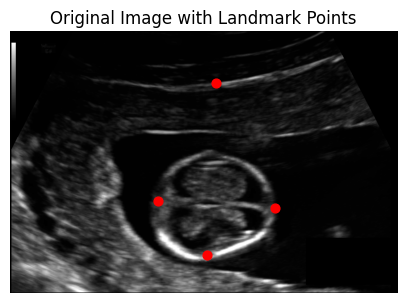

In [8]:
#this shows that noramlization works well, we'lls ee later
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define the functions for normalization and scaling
def normalize_coordinates(coordinates, image_size):
    normalized_coords = [(x / image_size[0], y / image_size[1]) for x, y in coordinates]
    return normalized_coords

def scale_coordinates(norm_coords, image_size):
    scaled_coords = [(int(x * image_size[0]), int(y * image_size[1])) for x, y in norm_coords]
    return scaled_coords

# Define the visualization function
def visualize_individual_points(image, coordinates):
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')
    for x, y in coordinates:
        plt.scatter([x], [y], c='r', s=40)
    plt.title("Original Image with Landmark Points")
    plt.axis('off')
    plt.show()

# Assume we have an original image and coordinates
original_image = Image.open('/content/Biparietal_Occipitofrontal-Diameter-Detection/images/003_HC.png').convert('L')
original_image_size = original_image.size  # Width, Height
coordinates = [(424, 105), (407, 462), (305, 349), (547, 363)]

# Normalize the coordinates
normalized_coordinates = normalize_coordinates(coordinates, original_image_size)

# If you were to resize the image, you would then scale the normalized coordinates
# For demonstration, let's say we keep the original image size
scaled_coordinates = scale_coordinates(normalized_coordinates, original_image_size)

# Convert image to array and normalize pixel values
image_array = np.array(original_image) / 255.0

# Visualize the scaled coordinates on the original (or resized) image
visualize_individual_points(image_array, scaled_coordinates)


It seems the given annotated images are not properly annotated which could lead to bad training and test accuracy.

original_image.size:  (800, 540)


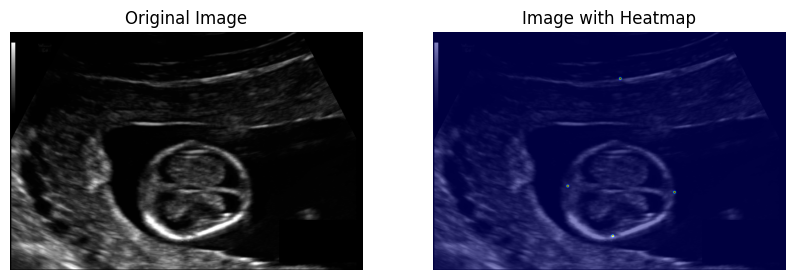

In [9]:
#try creating heatmaps and plotting it, for a specific image
def create_heatmap(coords, image_shape, sigma=2):
    # print('inside heatmap, shape: ', image_shape)
    heatmap = np.zeros(image_shape, dtype=np.float32)  # Initialize heatmap
    # print('initiallly, heatmap.size: ', heatmap.size)
    for x, y in coords:
        if y < image_shape[0] and x < image_shape[1]:
            heatmap[y, x] = 1  # Mark the landmark position with a 1
    heatmap = scipy.ndimage.gaussian_filter(heatmap, sigma=sigma)
    return heatmap

def visualize_image_and_heatmap(image, heatmap):
    # if image.shape != heatmap.shape:
    # if image.size != heatmap.size:
    #     print(image.size, heatmap.size, 'these are the values.')
    #     raise ValueError(f"Image and heatmap shapes do not match: {image.size} vs {heatmap.size}")
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray', aspect = 'equal')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    plt.imshow(heatmap, alpha=0.5, cmap='jet', aspect='equal')  # Overlay heatmap
    plt.title("Image with Heatmap")
    plt.axis('off')
    # ax.set_xlim([0, image.shape[1]])
    # ax.set_ylim([image.shape[0], 0])
    plt.show()

original_image = Image.open('/content/Biparietal_Occipitofrontal-Diameter-Detection/images/003_HC.png').convert('L')
print('original_image.size: ', original_image.size)
image = np.array(original_image)/ 255.0 #normalizing
my_coord = [(424, 105), (407, 462), (305, 349), (547, 363)] #wrote myself
heatmap = create_heatmap(my_coord,(original_image.size[1], original_image.size[0])) #these values are not scaled at all.
visualize_image_and_heatmap(image, heatmap)

it seems some images are indeed annotated wrong, as it shows even in the heatmaps

In [10]:
#check if there are any nulll values in any of the features
cols = [col for col in data.columns if data[col].isnull().any()]
print(cols) #no null values anywhere

[]


In [11]:
#converting coordinates into tuples to feed into heatmap function
all_coordinates = []
for index, row in data.iterrows():
    ofd_1 = (row['ofd_1_x'], row['ofd_1_y'])
    ofd_2 = (row['ofd_2_x'], row['ofd_2_y'])
    bpd_1 = (row['bpd_1_x'], row['bpd_1_y'])
    bpd_2 = (row['bpd_2_x'], row['bpd_2_y'])
    coordinates = [ofd_1, ofd_2, bpd_1, bpd_2]
    all_coordinates.append(coordinates)

scaled_coordinates:  [(135, 74), (130, 189), (97, 152), (175, 157)]


<ipython-input-12-e542acc0f56a>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)


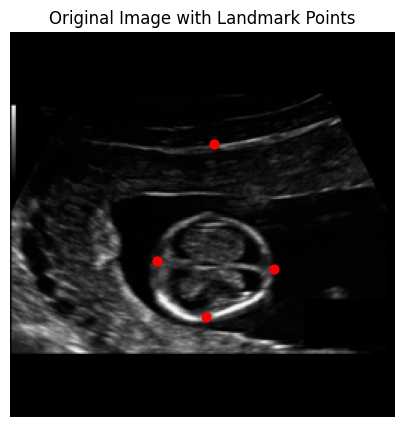

In [12]:
#works
def resize_image_with_padding(img, target_size):
    # Calculate the size preserving aspect ratio
    aspect_ratio = img.width / img.height
    if target_size[0] / target_size[1] > aspect_ratio:
        new_height = target_size[1]
        new_width = round(new_height * aspect_ratio)
    else:
        new_width = target_size[0]
        new_height = round(new_width / aspect_ratio)

    # Resize the image preserving aspect ratio
    resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)

    # Create a new image with the given size and black background
    padded_image = Image.new('L', target_size, 0)

    # Paste the resized image into center of the black background
    padding_top = (target_size[1] - new_height) // 2
    padding_left = (target_size[0] - new_width) // 2
    padded_image.paste(resized_image, (padding_left, padding_top))

    return padded_image, (padding_left, padding_top, new_width, new_height)

def scale_coordinates(coords, original_size, padding_info, target_size):
    # Unpack padding info
    padding_left, padding_top, new_width, new_height = padding_info
    # print('new_width (inside scale_cooords): ', new_width, 'new)height:(inside_scale_coords) ', new_height)
    # print('target_size: ', target_size)
    # Calculate the scaling factors
    x_scale = new_width / original_size[0]
    y_scale = new_height / original_size[1]

    # Apply scaling factors and offset by the padding
    scaled_coords = [(int(x * x_scale + padding_left), int(y * y_scale + padding_top)) for x, y in coords]

    return scaled_coords

original_image = Image.open('/content/Biparietal_Occipitofrontal-Diameter-Detection/images/003_HC.png').convert('L')
target_size = (256, 256)  # The desired output size
# Resize image and get padding offsets
resized_image, padding_info= resize_image_with_padding(original_image, target_size)
original_coordinates = [(424, 105), (407, 462), (305, 349), (547, 363)]
scaled_coordinates = scale_coordinates(original_coordinates, original_image.size, padding_info, target_size)
print('scaled_coordinates: ', scaled_coordinates)
# visualize_individual_points(original_image, original_coordinates)
visualize_individual_points(resized_image, scaled_coordinates)

Data being used is very bad and you can't achieve high accuracy with this data.

original_img.szie:  (800, 540)
resized_image.size:  (256, 256)
resized and scaled: 


<ipython-input-12-e542acc0f56a>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)


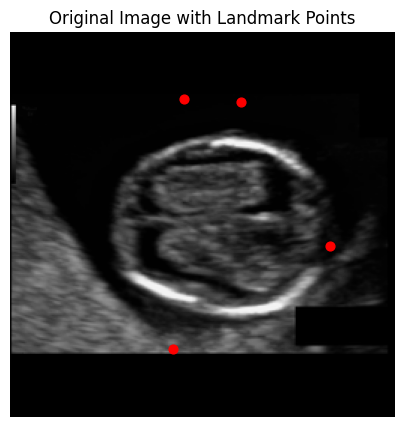

heatmap scaled: 


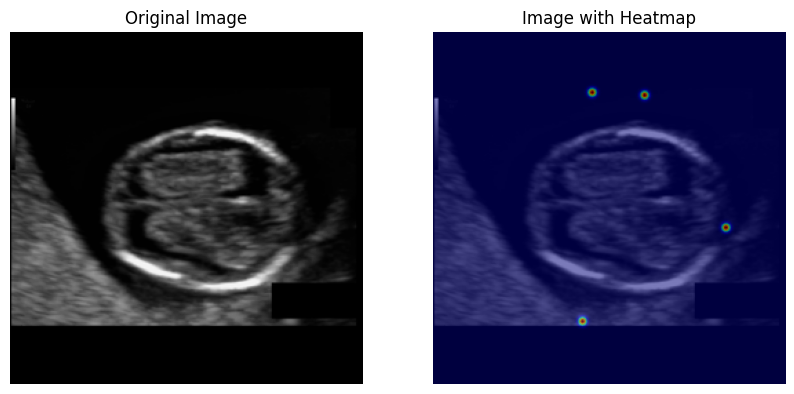

count:  0 done

original_img.szie:  (800, 540)
resized_image.size:  (256, 256)
resized and scaled: 


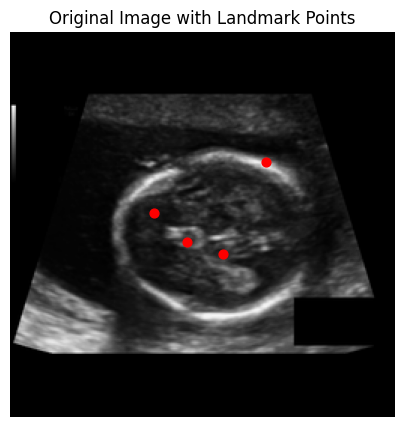

heatmap scaled: 


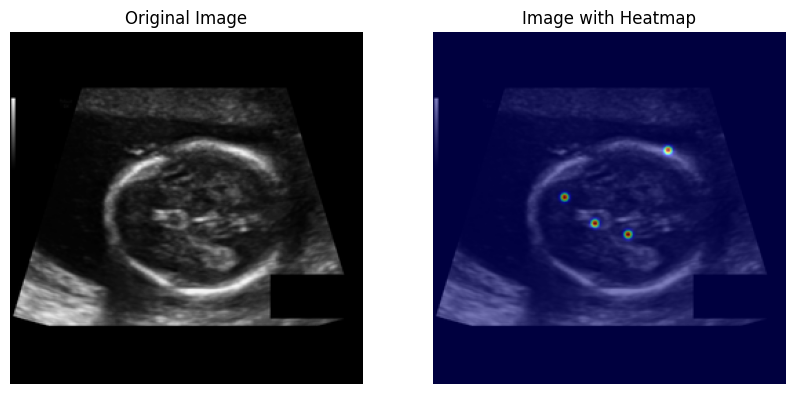

count:  1 done

original_img.szie:  (800, 540)
resized_image.size:  (256, 256)
resized and scaled: 


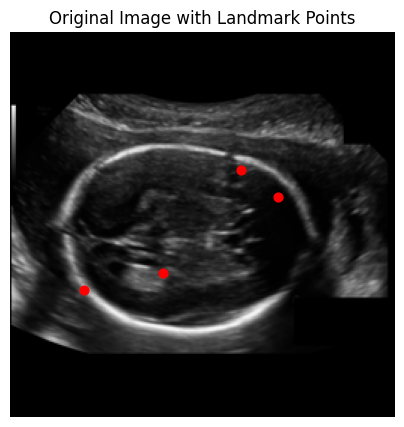

heatmap scaled: 


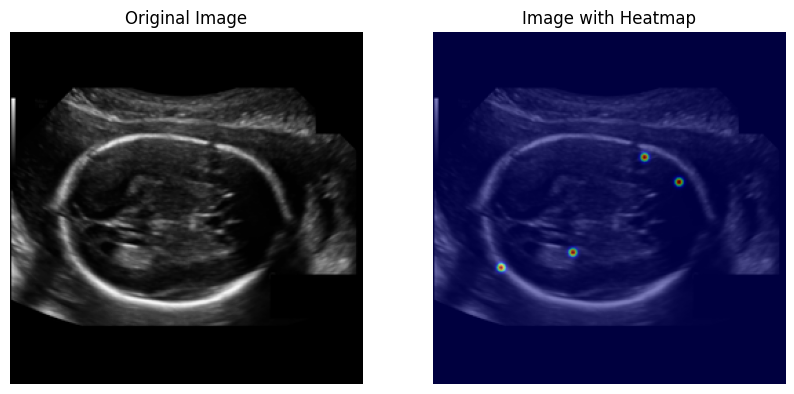

count:  2 done



In [13]:
#this works
base_path = '/content/Biparietal_Occipitofrontal-Diameter-Detection/images/'
image_paths = os.listdir(base_path)
count = 0
for image_path, coordinates in zip(image_paths, all_coordinates): #all_cooordinates isn't processed yet
        if count == 3:
                break
        full_path = os.path.join(base_path, image_path)
        with Image.open(full_path).convert('L') as img:
                print('original_img.szie: ', img.size)
                target_size = (256, 256)
                resized_image, padding_info= resize_image_with_padding(img, target_size)
                print('resized_image.size: ', resized_image.size)
                scaled_coordinates = scale_coordinates(coordinates, img.size, padding_info, target_size)
                scaled_heatmap = create_heatmap(scaled_coordinates,(target_size[1], target_size[0]))
                print('resized and scaled: ')
                visualize_individual_points(np.array(resized_image), scaled_coordinates)
                print('heatmap scaled: ')
                visualize_image_and_heatmap(resized_image, scaled_heatmap)
                print('count: ', count, 'done')
                count += 1
                print()

In [14]:
base_path = '/content/Biparietal_Occipitofrontal-Diameter-Detection/images/'
image_paths = os.listdir(base_path)
feature_dictionary = {'image': [], 'heatmap': []}

for image_path, coordinates in zip(image_paths, all_coordinates): #all_cooordinates isn't processed yet
        full_path = os.path.join(base_path, image_path)
        with Image.open(full_path).convert('L') as img:
                target_size = (256, 256)
                resized_image, padding_info= resize_image_with_padding(img, target_size)
                scaled_coordinates = scale_coordinates(coordinates, img.size, padding_info, target_size)
                scaled_heatmap = create_heatmap(scaled_coordinates,(target_size[1], target_size[0]))
                #  Store the resized image and heatmap in the feature dictionary
                feature_dictionary['image'].append(np.array(resized_image) / 255.0)  # Normalize the pixel values
                feature_dictionary['heatmap'].append(scaled_heatmap)

<ipython-input-12-e542acc0f56a>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)


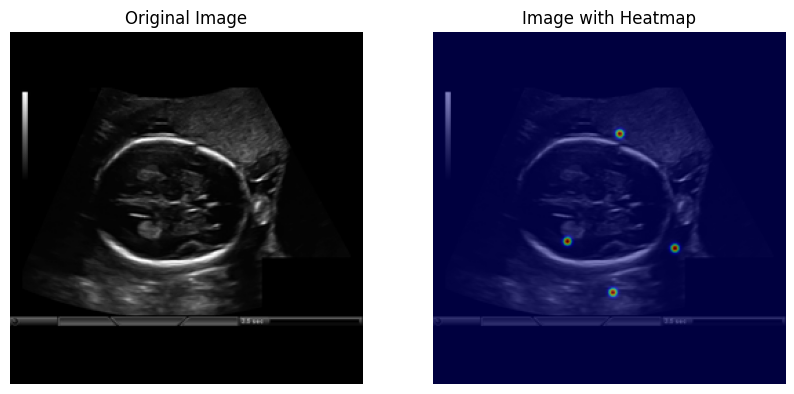

In [15]:
#take a random iimage and corresponding heatmap from  feature_dictionary and plot it
ran_img = feature_dictionary['image'][3]
ran_heatmap = feature_dictionary['heatmap'][3]
visualize_image_and_heatmap(ran_img, ran_heatmap)

original_img.shape:  (800, 540)
resized_img.shape:  (256, 256)


<ipython-input-12-e542acc0f56a>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)


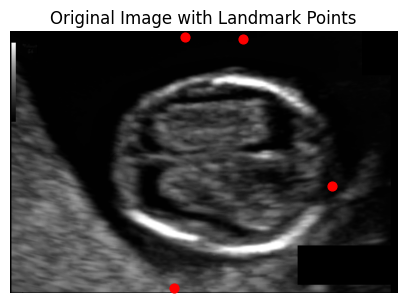

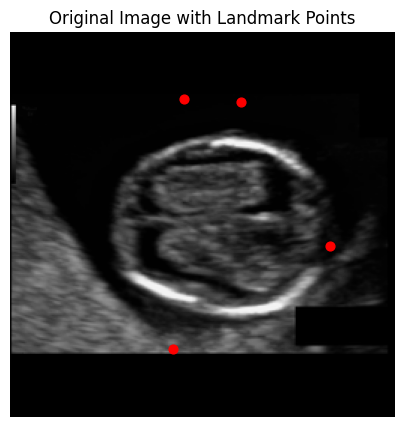

count: 0 done
original_img.shape:  (800, 540)
resized_img.shape:  (256, 256)


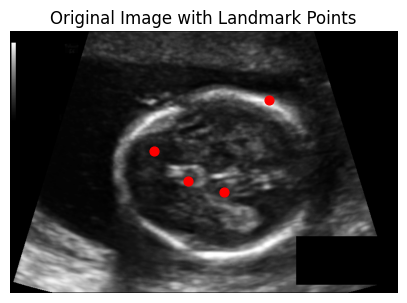

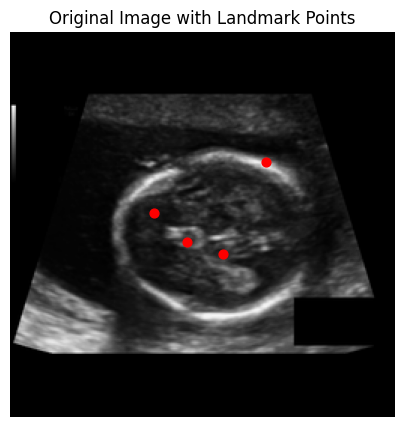

count: 1 done
original_img.shape:  (800, 540)
resized_img.shape:  (256, 256)


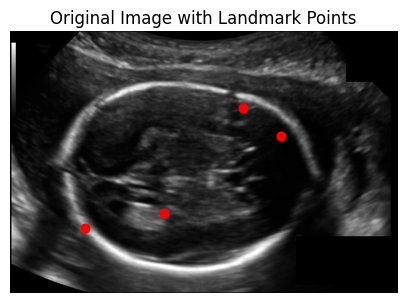

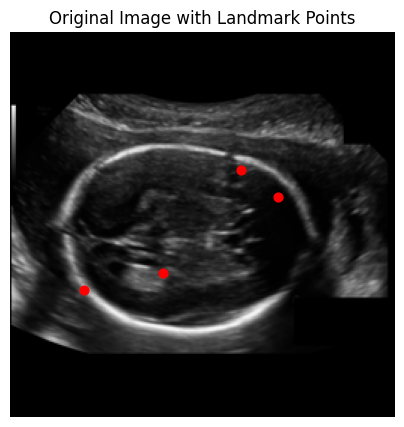

count: 2 done


In [16]:
# #works for visualization
base_path = '/content/Biparietal_Occipitofrontal-Diameter-Detection/images/'
image_paths = os.listdir(base_path)
count = 0
for image_path, coordinates in zip(image_paths, all_coordinates): #all_cooordinates isn't processed yet
        if count == 3:
                break
        full_path = os.path.join(base_path, image_path)
        with Image.open(full_path).convert('L') as img:
                print('original_img.shape: ', img.size)
                target_size = (256, 256)
                resized_image, padding_info= resize_image_with_padding(img, target_size)
                print('resized_img.shape: ', resized_image.size)
                scaled_coordinates = scale_coordinates(coordinates, img.size, padding_info, target_size)
                visualize_individual_points(img, coordinates)
                visualize_individual_points(resized_image, scaled_coordinates)
                print('count: {} done'.format(count))
                count += 1


<b> Now we've our training data in the form of feature_dictionary, which contains image and it's corresponding heatmap. </b>

In [17]:
#alternate method of separating data into train test
# import os
# import numpy as np
# from PIL import Image
# from sklearn.model_selection import train_test_split

# # Assuming 'all_coordinates' is a list of coordinates corresponding to 'image_paths'
# base_path = '/content/Biparietal_Occipitofrontal-Diameter-Detection/images/'
# image_paths = os.listdir(base_path)

# # Split the dataset into training and test sets
# image_paths_train, image_paths_test, coords_train, coords_test = train_test_split(
#     image_paths, all_coordinates, test_size=0.2, random_state=42
# )

# # Now define a function to process a set of images and coordinates
# def process_images(image_paths, coordinates, target_size=(256, 256)):
#     feature_dictionary = {'image': [], 'heatmap': []}
#     for image_path, coords in zip(image_paths, coordinates):
#         full_path = os.path.join(base_path, image_path)
#         with Image.open(full_path).convert('L') as img:
#             resized_image, padding_info = resize_image_with_padding(img, target_size)
#             scaled_coordinates = scale_coordinates(coords, img.size, padding_info, target_size)
#             scaled_heatmap = create_heatmap(scaled_coordinates, (target_size[1], target_size[0]))
#             feature_dictionary['image'].append(np.array(resized_image) / 255.0)  # Normalize the pixel values
#             feature_dictionary['heatmap'].append(scaled_heatmap)
#     return feature_dictionary

# # Process the training and test sets
# train_features = process_images(image_paths_train, coords_train)
# test_features = process_images(image_paths_test, coords_test)

# # Now you have 'train_features' and 'test_features' as separate dictionaries

# X_train = train_features['image']
# y_train = train_features['heatmap']
# X_test = test_features['image']
# y_test = test_features['heatmap'

In [34]:
#get a basic unet architecture, but split the dataset first
from sklearn.model_selection import train_test_split
X = np.array(feature_dictionary['image'])
y = np.array(feature_dictionary['heatmap'])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

497 125
497 125


In [20]:
X_train.shape #so we've 497 images of shape 256x256

(497, 256, 256)

In [21]:
y_train.shape #and corresponding to that, we've 497 heatmaps same size as image.

(497, 256, 256)

In [22]:
print(type(X_train), type(y_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [35]:
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

SEED = 1
# Convert numpy arrays to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Adding channel dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Adding channel dimension
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Normalize pixel values if not already done so during preprocessing
mean, std = 0.5, 0.5  # These are standard values for normalization, adjust if necessary
X_train_normalized = (X_train_tensor - mean) / std
X_test_normalized = (X_test_tensor - mean) / std

# Create TensorDataset
train_dataset = TensorDataset(X_train_normalized, y_train_tensor)
test_dataset = TensorDataset(X_test_normalized, y_test_tensor)

# CUDA check
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

# Dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=32, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Create DataLoaders
train_loader = DataLoader(train_dataset, **dataloader_args)
test_loader = DataLoader(test_dataset, **dataloader_args)

CUDA Available? True


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        self.e11 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.e12 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.e22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.e42 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))

        # Decoder
        xu3 = self.upconv3(xe42)
        xu33 = torch.cat([xu3, xe32], dim=1)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu2 = self.upconv2(xd32)
        xu22 = torch.cat([xu2, xe22], dim=1)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu1 = self.upconv1(xd22)
        xu11 = torch.cat([xu1, xe12], dim=1)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))

        # Output layer
        out = self.outconv(xd12)
        return out

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = UNet(1).to(device)

# Print model summary
from torchsummary import summary
summary(model, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
            Conv2d-2         [-1, 32, 256, 256]           9,248
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
            Conv2d-5         [-1, 64, 128, 128]          36,928
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
            Conv2d-8          [-1, 128, 64, 64]         147,584
         MaxPool2d-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]         295,168
           Conv2d-11          [-1, 256, 32, 32]         590,080
  ConvTranspose2d-12          [-1, 128, 64, 64]         131,200
           Conv2d-13          [-1, 128, 64, 64]         295,040
           Conv2d-14          [-1, 128,

In [25]:
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = []
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']
def calculate_pixel_accuracy(output, target, threshold=0.5):
    predicted = output > threshold
    true_positives = (predicted == target).sum().item()
    total_pixels = torch.numel(predicted)
    accuracy = true_positives / total_pixels
    return accuracy
# def train(model, device, train_loader, optimizer, scheduler, criterion): #adding scheduler and criterion
#   model.train()
#   pbar = tqdm(train_loader)
#   correct = 0
#   processed = 0
#   for batch_idx, (data, target) in enumerate(pbar):
#     # get samples
#     data, target = data.to(device), target.to(device)

#     # Init
#     optimizer.zero_grad()
#     # Predict
#     y_pred = model(data)

#     # Calculate loss
#     loss = criterion(y_pred, target)
#     train_losses.append(loss)
#     lrs.append(get_lr(optimizer))                           #adding extra line

#     # Backpropagation
#     loss.backward()
#     optimizer.step()
#     scheduler.step()                                        #adding extra line

#     # Update pbar-tqdm

#     pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#     correct += pred.eq(target.view_as(pred)).sum().item()
#     processed += len(data)

#                                                             #adding get_lr function below
#     pbar.set_description(desc= f'Loss={loss.item()} LR={get_lr(optimizer)} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
#     train_acc.append(100*correct/processed)
def train(model, device, train_loader, optimizer, scheduler, criterion):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        # Get samples
        data, target = data.to(device), target.to(device)

        # Initialize optimizer
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(data)

        # Calculate loss
        loss = criterion(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update progress bar description
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx}')
    return train_losses

test_loss = 0
# Modify the test function to include pixel-wise accuracy
def test(model, device, test_loader, criterion):
    global test_loss
    model.eval()
    total_accuracy = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            total_accuracy += calculate_pixel_accuracy(output, target)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    average_accuracy = total_accuracy / len(test_loader)
    print('\nTest set: Average loss: {:.4f}, Average Pixel Accuracy: {:.2f}%\n'.format(test_loss, average_accuracy * 100))

    return test_loss, test_losses

# def test_original(model, device, test_loader, criterion):            #added criterion here
#     model.eval()
#     test_loss = 0
#     correct = 0
#     # misclassified_images = []  # List to store misclassified images and labels
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += criterion(output, target).item()
#             # pred = output.argmax(dim=1, keepdim = True)  # Remove keepdim=True; now shape: [batch_size]
#             # correct += pred.eq(target.view_as(pred)).sum().item()        #modified this line
#     test_loss /= len(test_loader.dataset)
#     test_losses.append(test_loss)
#     Accuracy = 100. * correct / len(test_loader.dataset)
#     # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#     #     test_loss, correct, len(test_loader.dataset),
#     #     100. * correct / len(test_loader.dataset)))
#     print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
#     test_acc.append(100. * correct / len(test_loader.dataset))
#     return test_loss, test_losses

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 20) #if loss doens't decrease with 20 steps

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses = train(model, device, train_loader, optimizer, scheduler, criterion) #adding criterion as argument
    test_loss, test_losses = test(model, device, test_loader, criterion)
    scheduler.step(test_loss)

EPOCH: 0


Loss=0.0019342717714607716 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]



Test set: Average loss: 0.0025, Average Pixel Accuracy: 98.24%

EPOCH: 1


Loss=9.124143616645597e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.16it/s]



Test set: Average loss: 0.0001, Average Pixel Accuracy: 98.24%

EPOCH: 2


Loss=5.571438668994233e-05 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.16it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 3


Loss=3.221377482987009e-05 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 4


Loss=9.11549068405293e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 5


Loss=3.7525062452914426e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.14it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 6


Loss=2.944136667792918e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 7


Loss=2.9689999792026356e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 8


Loss=3.09138113152585e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.10it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 9


Loss=2.916280209319666e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 10


Loss=3.016483105966472e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 11


Loss=2.8317299438640475e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  2.00it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 12


Loss=2.7962121293967357e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 13


Loss=2.9185146104282467e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 14


Loss=2.9035475108685205e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 15


Loss=2.8009715151711134e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.90it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 16


Loss=2.821450379997259e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.11it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 17


Loss=2.708657120820135e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 18


Loss=2.7845696877193404e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 19


Loss=2.7330122520652367e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.10it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 20


Loss=2.7634139314614004e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 21


Loss=2.6751838504424086e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 22


Loss=2.685562776605366e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 23


Loss=2.5976898996304953e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 24


Loss=2.6144966795982327e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 25


Loss=2.690981546038529e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.00it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 26


Loss=2.552509613451548e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 27


Loss=2.537468844820978e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 28


Loss=2.587561766631552e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 29


Loss=2.5754000034794444e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 30


Loss=2.4954608761618147e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.10it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 31


Loss=2.512484570615925e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.10it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 32


Loss=2.459826646372676e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 33


Loss=2.496785100447596e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 34


Loss=2.510129434085684e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 35


Loss=2.548840257077245e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 36


Loss=2.5446668132644845e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.10it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 37


Loss=2.3730178781988798e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.10it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 38


Loss=2.429574124107603e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 39


Loss=2.410549313935917e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.03it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 40


Loss=2.4457156087009935e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 41


Loss=2.3716988835076336e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 42


Loss=2.3795696506567765e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.10it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 43


Loss=2.37208428188751e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 44


Loss=2.382410912105115e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 45


Loss=2.315092160642962e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 46


Loss=2.450981810397934e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 47


Loss=2.298899062225246e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 48


Loss=2.3461602722818498e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 49


Loss=2.392608621448744e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.10it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%



In [26]:
print(len(train_losses), len(test_losses)) #should be 800, 50

800 50


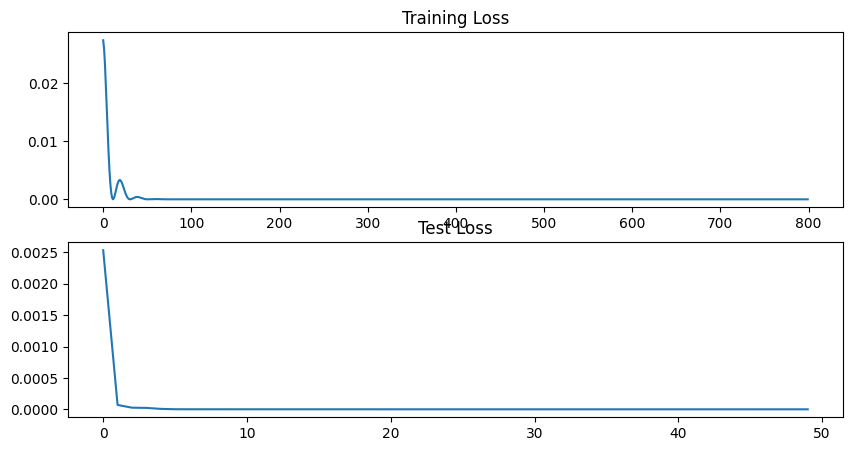

In [27]:
# t = [train_items.item() for train_items in train_losses]
# #plot the curve of loss : test_losses, train_losses
# fig, axs = plt.subplots(2,1,figsize=(15,10))
# axs[0, 0].plot(t)
# axs[0, 0].set_title("Training Loss")
# axs[0, 1].plot(test_losses)
# axs[0, 1].set_title("Test Loss")
train_loss_values = [loss.item() if not isinstance(loss, float) else loss for loss in train_losses]
test_loss_values = [loss if isinstance(loss, float) else loss.item() for loss in test_losses]
fig, axs = plt.subplots(2, 1, figsize=(10, 5))  # 2 rows, 1 column for subplots
axs[0].plot(train_loss_values)
axs[0].set_title("Training Loss")
axs[1].plot(test_loss_values)
axs[1].set_title("Test Loss")
plt.show()

In [28]:
#get the name of test images first
from sklearn.model_selection import train_test_split

# Assuming 'all_coordinates' and 'all_images' are your full datasets.
base_path = '/content/Biparietal_Occipitofrontal-Diameter-Detection/images/'
image_paths = [os.path.join(base_path, img) for img in sorted(os.listdir(base_path))]
all_images = np.array(feature_dictionary['image'])
all_coordinates = np.array(feature_dictionary['heatmap'])

# Split the dataset into training and test sets along with their corresponding image paths
X_train, X_test, y_train, y_test, image_paths_train, image_paths_test = train_test_split(
    all_images, all_coordinates, image_paths, test_size=0.2, random_state=42
)
print(len(image_paths_test)) # 125, same as no. of images in test_loader

125


torch.Size([32, 1, 256, 256])


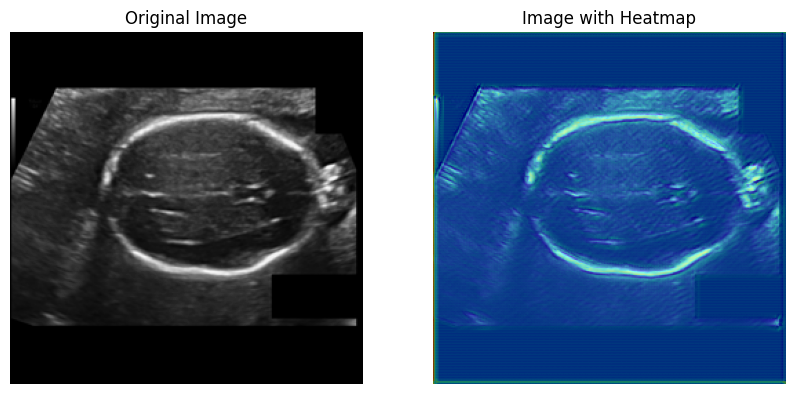

In [36]:
# def visualize_image_and_heatmap(image, heatmap):
#     if image.shape != heatmap.shape:
#         raise ValueError(f"Image and heatmap shapes do not match: {image.shape} vs {heatmap.shape}")
#     plt.figure(figsize=(10, 5))

#     image = image.cpu().numpy()  # Move tensor to CPU and convert to numpy
#     heatmap = heatmap.cpu().numpy()  # Move tensor to CPU and convert to numpy

#     plt.subplot(1, 2, 1)
#     plt.imshow(image[0], cmap='gray')  # Assuming single-channel image, select the channel with [0]
#     plt.title("Original Image")
#     plt.axis('off')

#     plt.subplot(1, 2, 2)
#     plt.imshow(image[0], cmap='gray')  # Assuming single-channel image, select the channel with [0]
#     plt.imshow(heatmap[0], alpha=0.5, cmap='jet')  # Overlay heatmap, select the channel with [0]
#     plt.title("Image with Heatmap")
#     plt.axis('off')

#     plt.show()
# def visualize_image_and_heatmap(image, heatmap):
#     if image.shape != heatmap.shape:
#         raise ValueError(f"Image and heatmap shapes do not match: {image.shape} vs {heatmap.shape}")
#     plt.figure(figsize=(10, 5))

#     # Check if tensors require grad and if so, detach them
#     if image.requires_grad:
#         image = image.detach()
#     if heatmap.requires_grad:
#         heatmap = heatmap.detach()

#     # Move tensors to CPU and convert to numpy if they are not already numpy arrays
#     if isinstance(image, torch.Tensor):
#         image = image.cpu().numpy()
#     if isinstance(heatmap, torch.Tensor):
#         heatmap = heatmap.cpu().numpy()

#     plt.subplot(1, 2, 1)
#     plt.imshow(image[0], cmap='gray')  # Assuming image is a batch of images, we take the first one
#     plt.title("Original Image")
#     plt.axis('off')

#     plt.subplot(1, 2, 2)
#     plt.imshow(image[0], cmap='gray')  # Assuming image is a batch of images, we take the first one
#     plt.imshow(heatmap[0], alpha=0.5, cmap='jet')  # Overlay heatmap, also assuming a batch
#     plt.title("Image with Heatmap")
#     plt.axis('off')

#     plt.show()
def visualize_image_and_heatmap(image, heatmap):
    if image.shape[1:] != heatmap.shape[1:]:
        raise ValueError(f"Image and heatmap shapes do not match: {image.shape} vs {heatmap.shape}")

    # Move to CPU and detach if needed
    image = image.cpu().detach() if image.requires_grad else image.cpu()
    heatmap = heatmap.cpu().detach() if heatmap.requires_grad else heatmap.cpu()

    # Convert to numpy arrays
    image_np = image.numpy()
    heatmap_np = heatmap.numpy()

    # Squeeze the channel dimension or select the first channel
    image_np = image_np[0, 0, :, :] if image_np.ndim == 4 else image_np[0, :, :]  # Assuming (batch_size, channels, H, W)
    heatmap_np = heatmap_np[0, 0, :, :] if heatmap_np.ndim == 4 else heatmap_np[0, :, :]  # Same assumption

    # Visualization
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image_np, cmap='gray')
    plt.imshow(heatmap_np, alpha=0.5, cmap='jet')  # Overlay heatmap
    plt.title("Image with Heatmap")
    plt.axis('off')
    plt.show()


#now get the final prediction on test dataset from the model in the form of heatmap, and convert those coordinates
def extract_coordinates_from_heatmap(heatmap, num_points=4):
    flat_indices = torch.topk(heatmap.view(-1), num_points).indices
    coords = [(int(idx % heatmap.shape[-1]), int(idx // heatmap.shape[-1])) for idx in flat_indices]

    return coords

for index, (data, target) in enumerate(test_loader):
    if(index == 1):
      data, target = data.to(device), target.to(device)
      output_heatmap = model(data)
      print(output_heatmap.shape)
      visualize_image_and_heatmap(data, output_heatmap)
#if above comes out alright

In [ ]:
import pandas as pd

# Step 1: Create a list of image names when you prepare your dataset.
# Suppose your image paths are stored in a list called image_paths_test.
image_names = [path.split('/')[-1] for path in image_paths_test]  # Assuming paths are stored in image_paths_test
# Step 2: Create a DataFrame to store results.
results = pd.DataFrame(columns=['image', 'predicted_coords'])
for idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    for i in range(data.size(0)):  # data.size(0) is the batch size
        single_image = data[i].unsqueeze(0)  # Add batch dimension
        single_target = target[i].unsqueeze(0)
        output_heatmap = model(single_image)
        # print('this is output_heatmap.shape: ', output_heatmap.shape, 'data.shape: ', single_image.shape)
        # Process output_heatmap as needed to get your predicted coordinates
        # heatmap_2d = output_heatmap.reshape(single_image.size)
        heatmap_tensor = torch.tensor(output_heatmap)
        # Here, you would call your function to extract coordinates from the heatmap
        predicted_coords = extract_coordinates_from_heatmap(heatmap_tensor, num_points=4)
        if(idx == 1):
          print('these are predicted_coords: ', predicted_coords)
        # Add the image name and predicted coordinates to the DataFrame
        results = results.append({'image': image_names[idx], 'predicted_coords': predicted_coords}, ignore_index=True)
# for batch_idx, (data, target) in enumerate(test_loader):
#     data, target = data.to(device), target.to(device)

#     # Iterate over each image in the batch
#     for i in range(data.size(0)):  # data.size(0) is the batch size
#         single_image = data[i].unsqueeze(0)  # Add batch dimension
#         single_target = target[i].unsqueeze(0)  # Add batch dimension

#         output_heatmap = model(single_image)
#         # Now output_heatmap is for a single image

#         # Process the output_heatmap as needed, e.g., extract coordinates
#         # Ensure you're handling a single heatmap, not a batch
#         single_output_heatmap_2d = output_heatmap.squeeze()  # Remove batch dimension
#         predicted_coords = extract_coordinates_from_heatmap(single_output_heatmap_2d.cpu().detach().numpy())

#         # Visualization or further processing...
#         visualize_image_and_heatmap(single_image.cpu().squeeze().numpy(), single_output_heatmap_2d.cpu().detach().numpy())
#         print("Predicted coordinates: ", predicted_coords)
#         results = results.append({'image': image_names[i], 'predicted_coords': predicted_coords}, ignore_index=True)

# Save to CSV
results.to_csv('predicted_coordinates.csv', index=False)


In [43]:
# Save the model state dictionary
model_save_path = 'model1_weights.pth'
torch.save(model.state_dict(), model_save_path)